# Нейронные сети и PyTorch

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Обзор Torch

### Пример линейной регрессии

In [2]:
n = 500
k = 3

x = torch.randn(n, k)
w_true = torch.Tensor((2., 3., -1.))
b_true = torch.Tensor([5])
y = torch.matmul(x, w_true) + b_true + 0.1 * torch.randn(n)
y

tensor([ 1.3685,  8.7908,  5.0439,  7.4406,  9.3069,  0.1100,  3.9745,  1.9773,
        -0.2101,  1.5074,  2.6463,  2.6971, 10.3059,  2.2816,  7.3997,  3.1381,
         3.3552,  5.8306,  6.0144,  1.0895,  3.9694,  0.0293, -0.9548, -1.0088,
         8.0888,  9.5221,  2.0988,  5.7875,  9.7178,  3.2557,  1.6679,  7.6928,
         3.7053,  5.7091,  0.6172, -0.7008,  5.4455,  4.0530,  2.0072,  9.6126,
        11.3166,  5.3249,  3.1584,  3.0313,  5.3448,  6.4349,  9.0624, -0.9032,
         1.6268,  6.6668,  6.1718,  6.4414, -1.9362, -1.5960,  1.7333, -0.6966,
         4.1313,  4.5002, -0.2795,  9.1267,  8.6861,  2.6245, 11.0080,  1.7145,
         8.4997,  1.7554,  3.2219,  4.1940, 10.7378, 11.2207,  7.8138,  9.0531,
         5.4241,  1.7210,  9.2160,  2.2474, 12.3296, 11.5030,  4.2077,  0.5261,
         3.7931,  4.7652, -4.3419,  0.8179,  2.6712,  5.8069,  4.3680,  3.8178,
         4.6861,  3.4138,  7.4736,  3.7610,  6.7474,  4.9629,  3.9063,  7.7326,
         8.9206,  9.3774,  7.2885, -1.07

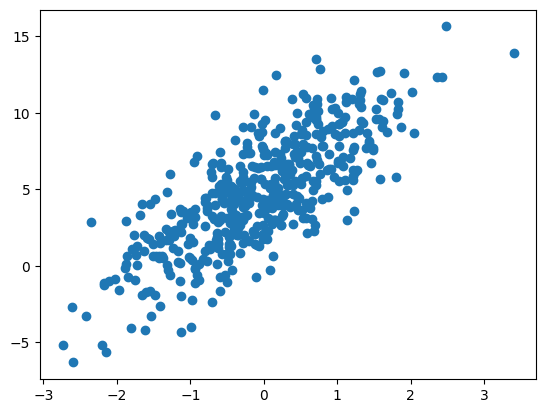

In [3]:
plt.scatter(x.numpy()[:, 1], y.numpy())

### Градиетнтый спуск, написанный на Torch

In [ ]:
epoch = 100
alpha = 0.001
w = torch.randn(k, requires_grad=True)
b = torch.randn(1, requires_grad=True)

for i in range(epoch):
    y_pred = torch.matmul(x, w) + b
    loss = torch.square(y_pred - y).sum()
    loss.backward()

    with torch.no_grad():
        w -= alpha * w.grad
        b -= alpha * b.grad

        w.grad = None
        b.grad = None

print(w, b)

tensor([ 1.9929,  3.0016, -0.9949], requires_grad=True) tensor([5.0018], requires_grad=True)


### Нелинейная регрессия на модельных данных

Генерируем синтетических данных: $y = sin(x) + \xi$

In [5]:
np.random.seed(42)
x = np.linspace(-2 * np.pi, 2 * np.pi, 500)
np.random.shuffle(x)
y = np.sin(x) + 0.1 * np.random.randn(*x.shape)

Предобрабатываем данные:

In [6]:
# Создание pandas DataFrame
df = pd.DataFrame({'x': x, 'y': y})

# Преобразуем в тензоры
X = torch.tensor(df['x'].values, dtype=torch.float32).view(-1, 1)
Y = torch.tensor(df['y'].values, dtype=torch.float32).view(-1, 1)

# Разделение на обучающую и тестовую выборки
train_size = int(0.8 * len(df))
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

Определим простую нейронную сеть:

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            # Линейный слой 
            nn.Linear(1, 64),
            # Нелинейность
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

Инициализируем модель, функцию потерь и оптимизатор:

In [8]:
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Цикл обучения:

In [9]:
epochs = 1000

# Перекючаем модель в режим обучения
model.train()

for epoch in range(epochs):
    # Обнуляем градиенты, чтобы стереть старые значения
    optimizer.zero_grad()
    # Получаем предсказания на трейне
    outputs = model(X_train)
    # На них вычисляем функцию потерь
    loss = criterion(outputs, Y_train)
    # Делаем backward
    loss.backward()
    # Делаем шаг оптимизации
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f"Эпоха {epoch+1}/{epochs}, Потери: {loss.item():.4f}")

Эпоха 100/1000, Потери: 0.0498
Эпоха 200/1000, Потери: 0.0116
Эпоха 300/1000, Потери: 0.0109
Эпоха 400/1000, Потери: 0.0119
Эпоха 500/1000, Потери: 0.0110
Эпоха 600/1000, Потери: 0.0117
Эпоха 700/1000, Потери: 0.0108
Эпоха 800/1000, Потери: 0.0127
Эпоха 900/1000, Потери: 0.0111
Эпоха 1000/1000, Потери: 0.0126


Визуализируем результаты:

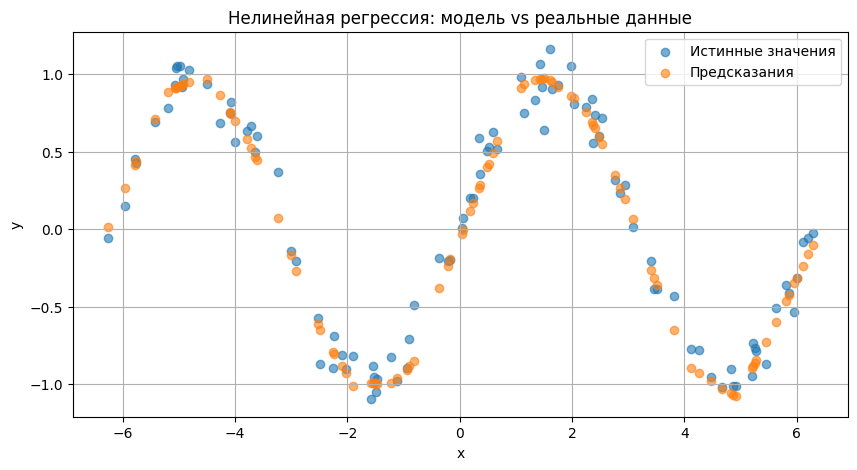

In [10]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)

# Визуализация результата
plt.figure(figsize=(10, 5))
plt.scatter(X_test.numpy(), Y_test.numpy(), label='Истинные значения', alpha=0.6)
plt.scatter(X_test.numpy(), predictions.numpy(), label='Предсказания', alpha=0.6)
plt.legend()
plt.title("Нелинейная регрессия: модель vs реальные данные")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

## Цикл обучения в Torch

### Класс загрузки данных

In [ ]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, idx):
        return self.X[idx]
    
    def __len__(self):
        return self.X.shape[0]